In [1]:
import json
from collections import Counter
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_size_category(area):
    if area < 2900:
        size = "S"
    elif area < 9500:
        size = "M"
    elif area < 31000:
        size = "L"
    else:
        size = "XL"
    return size

In [3]:
with open(f"/cvhci/data/document_analysis/DocLayNet/COCO/train.json", 'r') as f:
    coco_data = json.load(f)

In [4]:
image_id_to_doc_category = {img['id']: img['doc_category'] for img in coco_data['images']}
category_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}

In [5]:
document_categories = list(set([image_id_to_doc_category[annotation['image_id']] for annotation in coco_data['annotations']]))
class_dict = {entry['name']: {'S': 0, 'M': 0, 'L': 0, 'XL': 0} for entry in coco_data['categories']}
category_class_size_count_dict = {category: copy.deepcopy(class_dict) for category in document_categories}

In [6]:
for annotation in coco_data['annotations']:
    image_id = annotation['image_id']
    class_name = category_id_to_name[annotation['category_id']]
    doc_category = image_id_to_doc_category[image_id]
    size = get_size_category(annotation['area'])
    category_class_size_count_dict[doc_category][class_name][size] += 1

In [7]:
category_class_size_count_dict

{'patents': {'Caption': {'S': 1065, 'M': 150, 'L': 17, 'XL': 1},
  'Footnote': {'S': 6, 'M': 0, 'L': 0, 'XL': 2},
  'Formula': {'S': 73, 'M': 57, 'L': 19, 'XL': 2},
  'List-item': {'S': 2299, 'M': 2422, 'L': 2614, 'XL': 921},
  'Page-footer': {'S': 889, 'M': 13, 'L': 0, 'XL': 0},
  'Page-header': {'S': 10894, 'M': 596, 'L': 8, 'XL': 0},
  'Picture': {'S': 116, 'M': 611, 'L': 2849, 'XL': 7646},
  'Section-header': {'S': 3538, 'M': 795, 'L': 95, 'XL': 7},
  'Table': {'S': 3, 'M': 224, 'L': 390, 'XL': 887},
  'Text': {'S': 9129, 'M': 5299, 'L': 11101, 'XL': 12738},
  'Title': {'S': 272, 'M': 972, 'L': 343, 'XL': 10}},
 'financial_reports': {'Caption': {'S': 1191, 'M': 1539, 'L': 630, 'XL': 107},
  'Footnote': {'S': 169, 'M': 234, 'L': 116, 'XL': 31},
  'Formula': {'S': 0, 'M': 1, 'L': 0, 'XL': 0},
  'List-item': {'S': 4040, 'M': 8045, 'L': 8069, 'XL': 3130},
  'Page-footer': {'S': 17331, 'M': 2546, 'L': 95, 'XL': 64},
  'Page-header': {'S': 8403, 'M': 3822, 'L': 1083, 'XL': 194},
  'Pictu

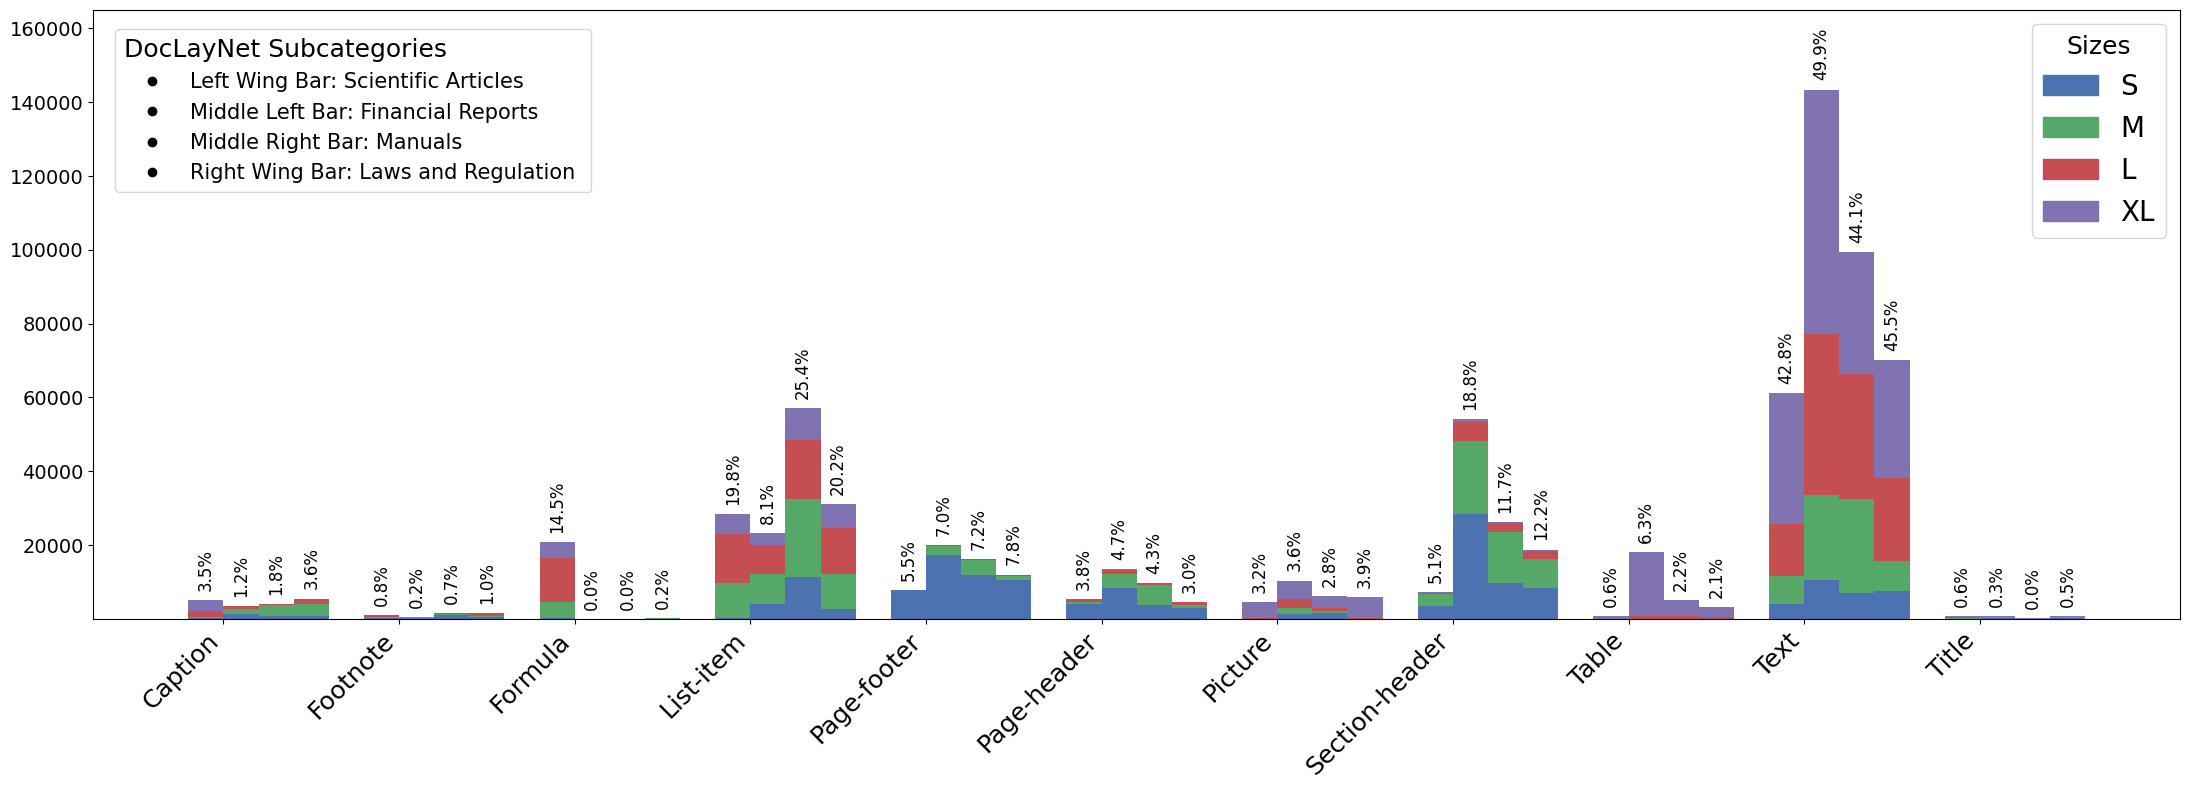

In [8]:
class_names = list(category_id_to_name.values())
sizes = ['S', 'M', 'L', 'XL']
used_doc_categories = ['scientific_articles', 'financial_reports' ,'manuals', 'laws_and_regulations']

x = np.arange(len(class_names)) * 2
bar_width = 0.4
offset = bar_width / 2

colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']

fig, ax = plt.subplots(figsize=(22, 8))

for j, dataset in enumerate(used_doc_categories):
    total_values_per_category = [sum(category_class_size_count_dict[dataset][cat].values()) for cat in class_names]
    
    bottom = np.zeros(len(class_names))
    for i, size in enumerate(sizes):
        values = [category_class_size_count_dict[dataset][cat][size] for cat in class_names]
        bars = ax.bar(x + j * bar_width - offset, values, bar_width, bottom=bottom, color=colors[i], label=f'{size}' if j == 0 and i == 0 else "")
        bottom += values

    percentages = [100 * total / sum(total_values_per_category) if sum(total_values_per_category) > 0 else 0
                   for total in total_values_per_category]
    for bar, percentage in zip(bars, percentages):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + bar.get_y() + 2500, f'{percentage:.1f}%', ha='center', rotation=90, va='bottom', fontsize=12)

#ax.set_xlabel('Classes with percentage class frequency value for each subcategory', fontsize=15)
#ax.set_ylabel('Frequency', fontsize=15)
#ax.set_title('Class Frequency for each DocLayNet Subcategory', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=18)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylim(top=165000)
ax.legend(handles=[
    plt.Rectangle((0, 0), 1, 1, color=colors[0], label='S'),
    plt.Rectangle((0, 0), 1, 1, color=colors[1], label='M'),
    plt.Rectangle((0, 0), 1, 1, color=colors[2], label='L'),
    plt.Rectangle((0, 0), 1, 1, color=colors[3], label='XL')
], title="Sizes", loc="upper right", title_fontsize=18, fontsize=20)

fig.legend(
    handles=[
        plt.Line2D([0], [0], color='black', label='Left Wing Bar: Scientific Articles', linestyle='', marker='o'),
        plt.Line2D([0], [0], color='black', label='Middle Left Bar: Financial Reports', linestyle='', marker='o'),
        plt.Line2D([0], [0], color='black', label='Middle Right Bar: Manuals', linestyle='', marker='o'),
        plt.Line2D([0], [0], color='black', label='Right Wing Bar: Laws and Regulation', linestyle='', marker='o')
    ],
    loc='upper left',
    bbox_to_anchor=(0.05, 0.97),
    title="DocLayNet Subcategories                 ",
    title_fontsize=18,
    fontsize=15
)

plt.tight_layout()
plt.savefig("/home/stewes/source-free-domain-adaptive-document-layout-analysis/Visualizations/DocLayNetSubcategoriesFrequencies.svg", format="svg")
plt.show()


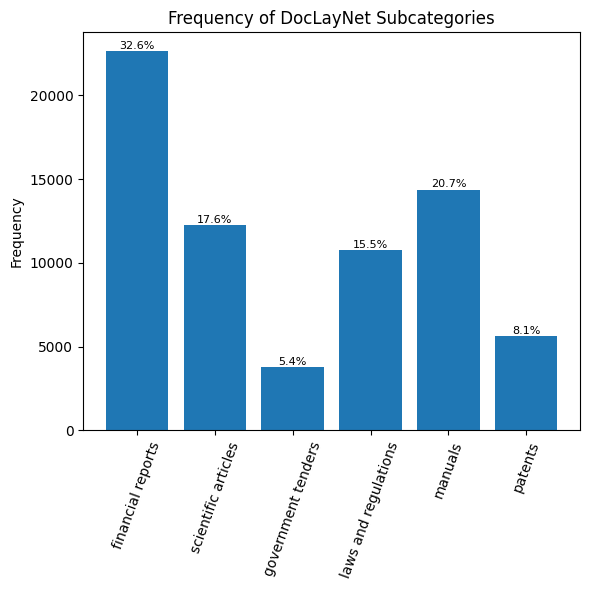

In [9]:
subcategory_counter = Counter([img['doc_category'] for img in coco_data['images']])

categories = list(subcategory_counter.keys())
categories = [cat.replace('_', ' ') for cat in categories]
values = list(subcategory_counter.values())

plt.figure(figsize=(6, 6))
bars = plt.bar(categories, values)

total = sum(values)
for bar, value in zip(bars, values):
    percent = (value / total) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10, f'{percent:.1f}%', ha='center', va='bottom', fontsize=8)

plt.title('Frequency of DocLayNet Subcategories')
plt.ylabel('Frequency')
plt.xticks(rotation=70)
plt.tight_layout()
plt.savefig("/home/stewes/source-free-domain-adaptive-document-layout-analysis/Visualizations/DocLayNetSubcategoriesFrequenciesB.svg", format="svg")
plt.show()

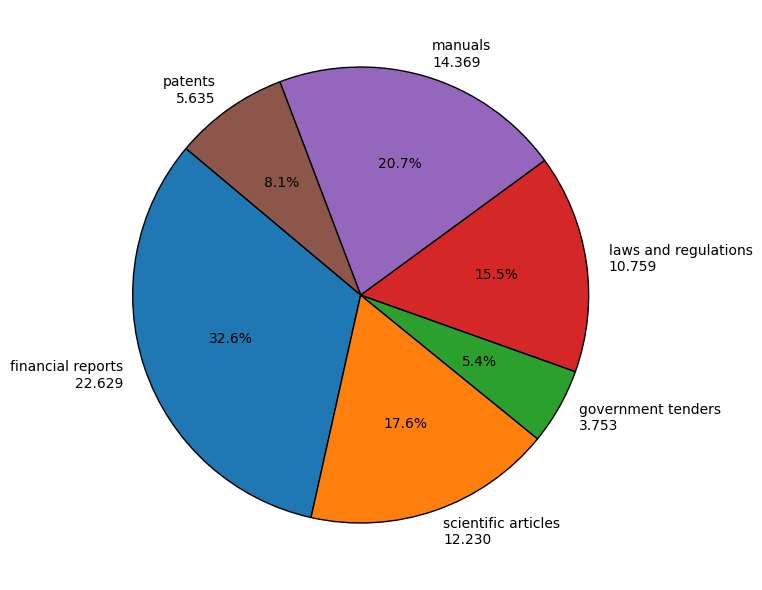

In [10]:
subcategory_counter = Counter([img['doc_category'] for img in coco_data['images']])
categories = list(subcategory_counter.keys())
categories = [cat.replace('_', ' ') for cat in categories]
values = list(subcategory_counter.values())
total = sum(values)

def autopct_format(pct):
    return f"{pct:.1f}%"

categories_with_absolute = [f"{cat}\n{val:,}".replace(",", ".") for cat, val in zip(categories, values)]

plt.figure(figsize=(8, 6))
plt.pie(values, labels=categories_with_absolute, autopct=autopct_format, startangle=140, wedgeprops={'edgecolor': 'black'})
plt.tight_layout()
plt.savefig("/home/stewes/source-free-domain-adaptive-document-layout-analysis/Visualizations/DocLayNetSubcategoriesFrequenciesPie.svg", format="svg")
plt.show()